# Machine Translation + Transformer

<img src = "../figures/transformer1.png" >

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip3 install torch==2.2.0

In [3]:
!pip3 install pyidaungsu

In [4]:
!pip3 install datasets

In [5]:
!pip3 install torchdata==0.7.1
!pip3 install torchtext==0.17.0


In [6]:
#!pip3 install portalocker
!pip3 install spacy
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 110.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
!pip3 install huggingface_hub


In [8]:
import torch, torchdata, torchtext
import torch.nn as nn
import torch.nn.functional as F
import pyidaungsu as pds

import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [9]:
# torch.cuda.get_device_name(0)

In [10]:
torch.__version__

'2.2.0+cu121'

In [11]:
torchtext.__version__

'0.17.0+cpu'

## 1. ETL: Loading the dataset

**Note**: Here I chose to translate English to German, simply it is easier for myself, since I don't understand German so it is difficult for me to imagine a sentence during inference.

In [12]:
from huggingface_hub import login

login()


In [11]:
import pandas as pd

def extract_sentences(file_path, column_name='sentences'):

    sentences = []

    with open(file_path, 'r') as file:
        for line in file:
            sentence = line.split('\t')[-1]  # Extract the last tab-separated value
            sentences.append(sentence.strip())  # Remove any leading/trailing whitespace

    return pd.Series(sentences, name=column_name)


en_file_path = '/content/ALT.en-my.en'
en_series = extract_sentences(en_file_path, column_name='en')
mm_file_path = '/content/ALT.en-my.my'
mm_series = extract_sentences(mm_file_path, column_name='my')
en_series.shape, mm_series.shape



((18089,), (18089,))

In [12]:
mm_series.tail()

,my
18084,ဗစ်တိုးရီးယား ရဲ ၏ အကြီးတန်း ပုလိပ် စုံထောက် ဘ...
18085,“ သူ့ ရဲ့ အစွဲအလမ်း က သူ့ ကို လုံးဝ ပို ကောင်း...
18086,ရထားလမ်း သို့ လျှပ်စစ် မီး ဖြတ်တောက် ခဲ့ သည့်အ...
18087,သူ လည်း မယ်ဘုန်းလ် တောင်ပိုင်း ရထား ဘူတာ မှ ၊ ...
18088,


In [13]:
en_series.tail()

,en
18084,Detective Senior Constable Barry Hills of Vict...
18085,"""I think his obsession just got the better of ..."
18086,Described as wearing a jacket similar to offic...
18087,He is also accused of stealing a tram on Frida...
18088,


In [14]:
newdf = pd.concat([en_series, mm_series], axis=1)

In [15]:
newdf.shape

(18089, 2)

In [16]:
newdf.tail()

,en,my
18084,Detective Senior Constable Barry Hills of Vict...,ဗစ်တိုးရီးယား ရဲ ၏ အကြီးတန်း ပုလိပ် စုံထောက် ဘ...
18085,"""I think his obsession just got the better of ...",“ သူ့ ရဲ့ အစွဲအလမ်း က သူ့ ကို လုံးဝ ပို ကောင်း...
18086,Described as wearing a jacket similar to offic...,ရထားလမ်း သို့ လျှပ်စစ် မီး ဖြတ်တောက် ခဲ့ သည့်အ...
18087,He is also accused of stealing a tram on Frida...,သူ လည်း မယ်ဘုန်းလ် တောင်ပိုင်း ရထား ဘူတာ မှ ၊ ...
18088,,


In [17]:
row_ids = [1789,1795, 1796, 1797, 1798, 1799,1800, 1801, 1802, 1803]
rows_data = newdf.loc[row_ids]  # Fetch rows for the given IDs

In [18]:
rows_data

,en,my
1789,Critics have raised concerns over Sir Alan hol...,ဝေဖန် သူ များ သည် ကဏ္ဍ နှစ် ခု စလုံး ကို ဆုပ်က...
1795,He presented his diagnosis yesterday at the an...,သူ သည် သူ ၏ ရောဂါ လက္ခဏာ ကို ဆန်ဒီကို တွင် ခန္...
1796,Asherman's syndrome is normally caused by a tr...,အက်စ်ရှာမန်း ၏ လက္ခဏာ သည် ပုံမှန် အားဖြင့် အတွ...
1797,"For example, it can occur after multiple proce...",ဥပမာ အားဖြင့် ၊ ၎င်း ကို “ ဒီ နှင့် စီ ” လုပ်ထ...
1798,Antelo said Kahlo tried to have children many ...,အန်တီလို က ကယ်လို ကို အကြိမ် အတော်များများ ကလေ...
1799,At present the condition could be diagnosed an...,လက်ရှိ အချိန် တွင် ထို အခြေအနေ သည် ဆေး ပညာ ဆို...
1800,Asherman's syndrome has been known since 1894 ...,အက်ရှားမန်း ၏ ရောဂါ လက္ခဏာ သည် ၎င်း ကို ပထမဆုံ...
1801,"""She kept attempting to have children with a u...",""" သူမ သည် ၎င်း ကို ပြုလုပ် ရန် မည်သည့် အခြေအနေ..."
1802,"Antelo, who has been working on connections be...",အနုပညာ နှင့် ဆေး ပညာ အကြား ဆက်သွယ် မှု များ ပေ...
1803,"In that image, Kahlo is shown lying on a hospi...",အဆိုပါ ပုံ တွင် ၊ ကယ်လို သည် ဆေးရုံ ကုတင် တစ် ...


In [19]:
mask = (newdf['en'].str.strip() != '') & (newdf['my'].str.strip() != '')

In [20]:
newdf = newdf.loc[mask]

In [21]:
newdf.shape

(18088, 2)

In [22]:
newdf.tail()

,en,my
18083,"""We have a very good recruiting policy and any...",“ ကျွန်တော် တို့ မှာ အရမ်း ကို ကောင်းမွန် တဲ့ ...
18084,Detective Senior Constable Barry Hills of Vict...,ဗစ်တိုးရီးယား ရဲ ၏ အကြီးတန်း ပုလိပ် စုံထောက် ဘ...
18085,"""I think his obsession just got the better of ...",“ သူ့ ရဲ့ အစွဲအလမ်း က သူ့ ကို လုံးဝ ပို ကောင်း...
18086,Described as wearing a jacket similar to offic...,ရထားလမ်း သို့ လျှပ်စစ် မီး ဖြတ်တောက် ခဲ့ သည့်အ...
18087,He is also accused of stealing a tram on Frida...,သူ လည်း မယ်ဘုန်းလ် တောင်ပိုင်း ရထား ဘူတာ မှ ၊ ...


In [23]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(newdf, train_size=0.9)
train, val = train_test_split(train, train_size=0.9)

In [24]:
train.shape, val.shape, test.shape

((14651, 2), (1628, 2), (1809, 2))

In [25]:
train.to_csv('train.csv')
test.to_csv('test.csv')
val.to_csv('val.csv')

In [25]:
from huggingface_hub import create_repo

repo_url = create_repo("NLPA3", repo_type="dataset", private=False)
print(f"Dataset created at: {repo_url}")


In [ ]:
from huggingface_hub import upload_file

# Define file paths and corresponding names in the repository
files_to_upload = {
    "/content/test.csv": "test.csv",
    "/content/train.csv": "train.csv",
    "/content/val.csv": "val.csv"
}

In [ ]:


# Hugging Face repo details
repo_id = "SHN157/NLPA3"
repo_type = "dataset"

# Upload files to Hugging Face
for local_path, repo_path in files_to_upload.items():
    upload_file(
        path_or_fileobj=local_path,
        path_in_repo=repo_path,
        repo_id=repo_id,
        repo_type=repo_type
    )



In [13]:
import torchtext, datasets

SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'my'

# train = Multi30k(split=('train'), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))
dataset = datasets.load_dataset('SHN157/NLPA3')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [14]:
type(dataset['train'])

datasets.arrow_dataset.Dataset

In [15]:
train = [(row['en'], row['my']) for row in dataset['train']]

In [16]:
train[0]

('"I\'m the only candidate who lives here with roots here." The Teamster\'s lawyer is originally from Edmonton, but has been living in Vancouver environs since 1991.',
 '" ကျွန်တော် က တစ် ဦး တည်း သော ဒီ မှာ မွေး ကတည်းက နေ လာ တဲ့ ကိုယ်စားလှယ်လောင်း ဖြစ် ပါ တယ် ။ " တီးမ်စတား ရဲ့ ရှေ့နေ သည် အစ က အက်မွန်တန် က ဖြစ် ပါ သည် ၊ သို့သော် ဗန်ကိုဗာ အန်ဗာရွန်းစ် မှာ ၁၉၉၁ ခုနှစ် ကတည်းက နေ လာ ခဲ့ ပါ သည် ။')

## 2. EDA - simple investigation

In [17]:
#let's take a look at one example of train
sample = train[0]
sample

('"I\'m the only candidate who lives here with roots here." The Teamster\'s lawyer is originally from Edmonton, but has been living in Vancouver environs since 1991.',
 '" ကျွန်တော် က တစ် ဦး တည်း သော ဒီ မှာ မွေး ကတည်းက နေ လာ တဲ့ ကိုယ်စားလှယ်လောင်း ဖြစ် ပါ တယ် ။ " တီးမ်စတား ရဲ့ ရှေ့နေ သည် အစ က အက်မွန်တန် က ဖြစ် ပါ သည် ၊ သို့သော် ဗန်ကိုဗာ အန်ဗာရွန်းစ် မှာ ၁၉၉၁ ခုနှစ် ကတည်းက နေ လာ ခဲ့ ပါ သည် ။')

In [18]:
train_size = len(train)
train_size

14651

Since 29001 is plenty,, we gonna call `random_split` to train, val and test

In [19]:
# train, val, test = train.random_split(total_length=train_size, weights = {"train": 0.7, "val": 0.2, "test": 0.1}, seed=999)
val = [(row['en'], row['my']) for row in dataset['validation']]
test = [(row['en'], row['my']) for row in dataset['test']]

In [20]:
train_size = len(train)
train_size

14651

In [21]:
val_size = len(val)
val_size

1628

In [22]:
test_size = len(test)
test_size

1809

## 3. Preprocessing

### Tokenizing

**Note**: the models must first be downloaded using the following on the command line:
```
python3 -m spacy download en_core_web_sm
python3 -m spacy download de_core_news_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

In [23]:
# !python3 -m spacy download en_core_web_sm
# !python3 -m spacy download de_core_news_sm

In [24]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [25]:
# Myanmar word tokenizer.
def mmtokenizer(sentence):
    return pds.tokenize(sentence, form="word")

In [26]:
from torchtext.data.utils import get_tokenizer
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TRG_LANGUAGE] = mmtokenizer

In [27]:
import sys
#example of tokenization of the english part
print("Sentence: ", sample[1])
sys.stdout.flush()
print("Tokenization: ", token_transform[TRG_LANGUAGE](sample[1]))

Sentence:  " ကျွန်တော် က တစ် ဦး တည်း သော ဒီ မှာ မွေး ကတည်းက နေ လာ တဲ့ ကိုယ်စားလှယ်လောင်း ဖြစ် ပါ တယ် ။ " တီးမ်စတား ရဲ့ ရှေ့နေ သည် အစ က အက်မွန်တန် က ဖြစ် ပါ သည် ၊ သို့သော် ဗန်ကိုဗာ အန်ဗာရွန်းစ် မှာ ၁၉၉၁ ခုနှစ် ကတည်းက နေ လာ ခဲ့ ပါ သည် ။
Tokenization:  ['"', 'ကျွန်တော်', 'က', 'တစ်', 'ဦးတည်း', 'သော', 'ဒီ', 'မှာ', 'မွေး', 'က', 'တည်း', 'က', 'နေ', 'လာ', 'တဲ့', 'ကိုယ်စားလှယ်လောင်း', 'ဖြစ်', 'ပါ', 'တယ်', '။', '"', 'တီးမ်စတား', 'ရဲ့', 'ရှေ့', 'နေ', 'သည်', 'အစ', 'က', 'အက်မွန်တန်', 'က', 'ဖြစ်', 'ပါ', 'သည်', '၊', 'သို့သော်', 'ဗန်', 'ကိုဗာအန်ဗာရွန်းစ်', 'မှာ', '၁၉၉၁', 'ခုနှစ်', 'က', 'တည်း', 'က', 'နေ', 'လာ', 'ခဲ့', 'ပါ', 'သည်', '။']


In [28]:
sample[1]

'" ကျွန်တော် က တစ် ဦး တည်း သော ဒီ မှာ မွေး ကတည်းက နေ လာ တဲ့ ကိုယ်စားလှယ်လောင်း ဖြစ် ပါ တယ် ။ " တီးမ်စတား ရဲ့ ရှေ့နေ သည် အစ က အက်မွန်တန် က ဖြစ် ပါ သည် ၊ သို့သော် ဗန်ကိုဗာ အန်ဗာရွန်းစ် မှာ ၁၉၉၁ ခုနှစ် ကတည်းက နေ လာ ခဲ့ ပါ သည် ။'

In [29]:
token_transform[TRG_LANGUAGE](sample[1])

['"',
 'ကျွန်တော်',
 'က',
 'တစ်',
 'ဦးတည်း',
 'သော',
 'ဒီ',
 'မှာ',
 'မွေး',
 'က',
 'တည်း',
 'က',
 'နေ',
 'လာ',
 'တဲ့',
 'ကိုယ်စားလှယ်လောင်း',
 'ဖြစ်',
 'ပါ',
 'တယ်',
 '။',
 '"',
 'တီးမ်စတား',
 'ရဲ့',
 'ရှေ့',
 'နေ',
 'သည်',
 'အစ',
 'က',
 'အက်မွန်တန်',
 'က',
 'ဖြစ်',
 'ပါ',
 'သည်',
 '၊',
 'သို့သော်',
 'ဗန်',
 'ကိုဗာအန်ဗာရွန်းစ်',
 'မှာ',
 '၁၉၉၁',
 'ခုနှစ်',
 'က',
 'တည်း',
 'က',
 'နေ',
 'လာ',
 'ခဲ့',
 'ပါ',
 'သည်',
 '။']

A function to tokenize our input.

In [30]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        yield token_transform[language](data_sample[language_index[language]]) #either first or second index

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [31]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [32]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln),
                                                    min_freq=2,   #The minimum frequency needed to include a token in the vocabulary. if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end
# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [33]:
#see some example
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[832, 18, 12, 0, 12]

In [34]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 1816, for example
mapping[1891]

'university'

In [35]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [36]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [37]:
#check unique vocabularies
len(mapping)

15076

## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [38]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], # Tokenization
                                               vocab_transform[ln], # Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

Create train, val, and test dataloaders

In [39]:
batch_size = 32

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val,   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

Let's test the train loader.

In [40]:
for en, _, de in train_loader:
    break

In [41]:
from IPython.display import display
display("English shape: ", en.shape)  # (batch_size, seq len)
display("Myanmar shape: ", de.shape)   # (batch_size, seq len)

'English shape: '

torch.Size([32, 68])

'Myanmar shape: '

torch.Size([32, 122])

## 5. Design the model

<img src="../figures/transformer-encoder.png" >

### Encoder Layer

In [42]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        return src

### Encoder

In [43]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 500):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)

    def forward(self, src, src_mask):

        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len    = src.shape[1]

        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]

        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]

        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]

        return src


### Mutli Head Attention Layer

<img src = "../figures/transformer-attention.png" width="700">

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$

In [44]:
# MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
# forward(src, src, src, src_mask)
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)

        #Additional linear layer additive attention
        self.q_proj = nn.Linear(self.head_dim, self.head_dim)
        self.k_proj = nn.Linear(self.head_dim, self.head_dim)
        self.energy_proj = nn.Linear(self.head_dim, 1)

        self.fc_o     = nn.Linear(hid_dim, hid_dim)

        self.dropout  = nn.Dropout(dropout)

        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]

        batch_size = query.shape[0]
        seq_len_q = query.shape[1]
        seq_len_k = key.shape[1]
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        #Q=K=V: [batch_size, src len, hid_dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch_size, n heads, query len, head_dim]

        q_encoded = self.q_proj(Q).view(batch_size, self.n_heads, seq_len_q, 1, self.head_dim)
        k_encoded = self.k_proj(K).view(batch_size, self.n_heads, 1, seq_len_k, self.head_dim)

        energy = torch.tanh(q_encoded + k_encoded)
        # energy = self.vt(energy).view(batch_size, self.n_heads, q_len, k_len @ self.n_heads, 1)
        energy = self.energy_proj(energy).squeeze(-1)

        #Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        #energy = [batch_size, n heads, query len, key len]

        #for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]

        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]

        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]

        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]

        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]

        return x, attention

### Position-wise Feedforward Layer

In [45]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

### Decoder Layer

<img src = "../figures/transformer-decoder.png" >

In [46]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]

        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        return trg, attention

### Decoder

In [47]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads,
                 pf_dim, dropout, device,max_length = 500):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]

        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]

        return output, attention

### Putting them together (become Seq2Seq!)

Our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

In [48]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        #src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):

        #trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):

        #src = [batch size, src len]
        #trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        return output, attention

## 6. Training

In [49]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [50]:
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TRG_LANGUAGE])
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT,
              device)

dec = Decoder(OUTPUT_DIM,
              HID_DIM,
              DEC_LAYERS,
              DEC_HEADS,
              DEC_PF_DIM,
              DEC_DROPOUT,
              device)

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

In [51]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              enc_dropout,
              device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(15076, 256)
    (pos_embedding): Embedding(500, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (q_proj): Linear(in_features=32, out_features=32, bias=True)
          (k_proj): Linear(in_features=32, out_features=32, bias=True)
          (energy_proj): Linear(in_features=32, out_features=1, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feedforward): PositionwiseFeed

In [52]:

#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        display(f'{item:>6}')
    display(f'______\n{sum(params):>6}')

count_parameters(model)

'3859456'

'128000'

'   256'

'   256'

'   256'

'   256'

' 65536'

'   256'

' 65536'

'   256'

' 65536'

'   256'

'  1024'

'    32'

'  1024'

'    32'

'    32'

'     1'

' 65536'

'   256'

'131072'

'   512'

'131072'

'   256'

'   256'

'   256'

'   256'

'   256'

' 65536'

'   256'

' 65536'

'   256'

' 65536'

'   256'

'  1024'

'    32'

'  1024'

'    32'

'    32'

'     1'

' 65536'

'   256'

'131072'

'   512'

'131072'

'   256'

'   256'

'   256'

'   256'

'   256'

' 65536'

'   256'

' 65536'

'   256'

' 65536'

'   256'

'  1024'

'    32'

'  1024'

'    32'

'    32'

'     1'

' 65536'

'   256'

'131072'

'   512'

'131072'

'   256'

'2823936'

'128000'

'   256'

'   256'

'   256'

'   256'

'   256'

'   256'

' 65536'

'   256'

' 65536'

'   256'

' 65536'

'   256'

'  1024'

'    32'

'  1024'

'    32'

'    32'

'     1'

' 65536'

'   256'

' 65536'

'   256'

' 65536'

'   256'

' 65536'

'   256'

'  1024'

'    32'

'  1024'

'    32'

'    32'

'     1'

' 65536'

'   256'

'131072'

'   512'

'131072'

'   256'

'   256'

'   256'

'   256'

'   256'

'   256'

'   256'

' 65536'

'   256'

' 65536'

'   256'

' 65536'

'   256'

'  1024'

'    32'

'  1024'

'    32'

'    32'

'     1'

' 65536'

'   256'

' 65536'

'   256'

' 65536'

'   256'

' 65536'

'   256'

'  1024'

'    32'

'  1024'

'    32'

'    32'

'     1'

' 65536'

'   256'

'131072'

'   512'

'131072'

'   256'

'   256'

'   256'

'   256'

'   256'

'   256'

'   256'

' 65536'

'   256'

' 65536'

'   256'

' 65536'

'   256'

'  1024'

'    32'

'  1024'

'    32'

'    32'

'     1'

' 65536'

'   256'

' 65536'

'   256'

' 65536'

'   256'

' 65536'

'   256'

'  1024'

'    32'

'  1024'

'    32'

'    32'

'     1'

' 65536'

'   256'

'131072'

'   512'

'131072'

'   256'

'2823936'

' 11031'

'______\n13747328'

In [53]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [54]:
def train(model, loader, optimizer, criterion, clip, loader_length):

    model.train()

    epoch_loss = 0

    for src, src_len, trg in loader:

        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])

        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos

        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [55]:
def evaluate(model, loader, criterion, loader_length):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for src, src_len, trg in loader:

            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / loader_length

### Putting everything together

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

**Note: similar to CNN, this model always has a teacher forcing ratio of 1, i.e. it will always use the ground truth next token from the target sequence (this is simply because CNN do everything in parallel so we cannot have the next token). This means we cannot compare perplexity values against the previous models when they are using a teacher forcing ratio that is not 1. To understand this, try run previous tutorials with teaching forcing ratio of 1, you will get very low perplexity.  **   

In [56]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [57]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [58]:
import torch

torch.cuda.empty_cache()
torch.backends.cudnn.benchmark = True


In [59]:
best_valid_loss = float('inf')
num_epochs = 10
clip       = 1

save_path = f'/content/drive/MyDrive/Colab_Notebooks/NLP/models/{model.__class__.__name__}-additive.pt'
model_name = f'{model.__class__.__name__}-additive.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):

    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)


    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)

    display(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    display(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    display(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    #lower perplexity is better

'Epoch: 01 | Time: 1m 39s'

'\tTrain Loss: 5.123 | Train PPL: 167.856'

'\t Val. Loss: 4.337 |  Val. PPL:  76.501'

'Epoch: 02 | Time: 1m 39s'

'\tTrain Loss: 4.200 | Train PPL:  66.675'

'\t Val. Loss: 4.062 |  Val. PPL:  58.071'

'Epoch: 03 | Time: 1m 39s'

'\tTrain Loss: 3.838 | Train PPL:  46.453'

'\t Val. Loss: 3.915 |  Val. PPL:  50.155'

'Epoch: 04 | Time: 1m 39s'

'\tTrain Loss: 3.563 | Train PPL:  35.263'

'\t Val. Loss: 3.855 |  Val. PPL:  47.250'

'Epoch: 05 | Time: 1m 39s'

'\tTrain Loss: 3.321 | Train PPL:  27.685'

'\t Val. Loss: 3.848 |  Val. PPL:  46.901'

'Epoch: 06 | Time: 1m 39s'

'\tTrain Loss: 3.098 | Train PPL:  22.143'

'\t Val. Loss: 3.862 |  Val. PPL:  47.571'

'Epoch: 07 | Time: 1m 39s'

'\tTrain Loss: 2.890 | Train PPL:  18.002'

'\t Val. Loss: 3.896 |  Val. PPL:  49.218'

'Epoch: 08 | Time: 1m 39s'

'\tTrain Loss: 2.699 | Train PPL:  14.863'

'\t Val. Loss: 3.968 |  Val. PPL:  52.902'

'Epoch: 09 | Time: 1m 38s'

'\tTrain Loss: 2.523 | Train PPL:  12.460'

'\t Val. Loss: 4.049 |  Val. PPL:  57.337'

'Epoch: 10 | Time: 1m 39s'

'\tTrain Loss: 2.359 | Train PPL:  10.583'

'\t Val. Loss: 4.124 |  Val. PPL:  61.791'

Text(0, 0.5, 'loss')

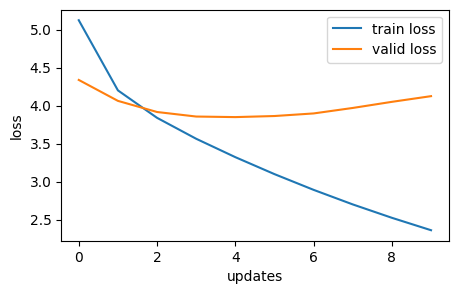

In [60]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [61]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

display(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

'| Test Loss: 3.815 | Test PPL:  45.389 |'

In [62]:
import pickle

param = {
    'token_transform': token_transform,
    'vocab_transform': vocab_transform,
}
param_name = 'param-additive.pkl'
pickle.dump(param, open('/content/drive/MyDrive/Colab_Notebooks/NLP/models/param-additive.pkl', 'wb'))

## 7. Test on some random news

In [63]:
sample[0]

'"I\'m the only candidate who lives here with roots here." The Teamster\'s lawyer is originally from Edmonton, but has been living in Vancouver environs since 1991.'

In [64]:
sample[1]

'" ကျွန်တော် က တစ် ဦး တည်း သော ဒီ မှာ မွေး ကတည်းက နေ လာ တဲ့ ကိုယ်စားလှယ်လောင်း ဖြစ် ပါ တယ် ။ " တီးမ်စတား ရဲ့ ရှေ့နေ သည် အစ က အက်မွန်တန် က ဖြစ် ပါ သည် ၊ သို့သော် ဗန်ကိုဗာ အန်ဗာရွန်းစ် မှာ ၁၉၉၁ ခုနှစ် ကတည်းက နေ လာ ခဲ့ ပါ သည် ။'

In [65]:
src_text = text_transform[SRC_LANGUAGE](sample[0]).to(device)
src_text

tensor([    2,    11,    51,   804,     4,    87,   572,    45,   872,   832,
           21,  8385,   832,     6,    11,    14, 12727,    20,  1196,    18,
         1288,    24,  8910,     5,    48,    26,    35,  1097,    10,  3128,
        13629,   100,  3068,     6,     3], device='cuda:0')

In [66]:
trg_text = text_transform[TRG_LANGUAGE](sample[1]).to(device)
trg_text

tensor([    2,    34,    65,    11,    15,  1687,    10,    87,    31,  2529,
           11,   360,    11,    32,    46,    58,   862,    19,    23,    39,
            8,    34,  8290,    51,   624,    32,     4,   647,    11, 10157,
           11,    19,    23,     4,     7,   364,  1807,  7373,    31,  2456,
           63,    11,   360,    11,    32,    46,     5,    23,     4,     8,
            3], device='cuda:0')

In [67]:
src_text = src_text.reshape(1, -1)  #because batch_size is 1

In [68]:
trg_text = trg_text.reshape(1, -1)

In [69]:
src_text.shape, trg_text.shape

(torch.Size([1, 35]), torch.Size([1, 51]))

In [70]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [71]:
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output, attentions = model(src_text, trg_text) #turn off teacher forcing

In [72]:
output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 51, 11031])

Since batch size is 1, we just take off that dimension

In [73]:
output = output.squeeze(0)

In [74]:
output.shape

torch.Size([51, 11031])

We shall remove the first token since it's zeroes anyway

In [75]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([50, 11031])

Then we just take the top token with highest probabilities

In [76]:
output_max = output.argmax(1) #returns max indices

In [77]:
output_max

tensor([ 266,    4,  360,   56,   10,  120,   92,   16,    5,  360,   11,  360,
          10,    5,  120,   54,    4,   39,    7,   34,    3,   51,  117,   32,
          58,    8,   31,  360,   11,  360,   46,   39,    8,    3,   16, 7373,
          31,  142,   63,   11,  360,   11,  360,    5,    5,    4,    4,    8,
           3,    3], device='cuda:0')

Get the mapping of the target language

In [78]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [79]:
for token in output_max:
    display(mapping[token.item()])

'ဒါ'

'သည်'

'တည်း'

'ယောက်'

'သော'

'အချိန်'

'ဟာ'

'သူ'

'ခဲ့'

'တည်း'

'က'

'တည်း'

'သော'

'ခဲ့'

'အချိန်'

'တွေ'

'သည်'

'တယ်'

'၊'

'"'

'<eos>'

'ရဲ့'

'နောက်'

'နေ'

'တဲ့'

'။'

'မှာ'

'တည်း'

'က'

'တည်း'

'လာ'

'တယ်'

'။'

'<eos>'

'သူ'

'ကိုဗာအန်ဗာရွန်းစ်'

'မှာ'

'သူမ'

'ခုနှစ်'

'က'

'တည်း'

'က'

'တည်း'

'ခဲ့'

'ခဲ့'

'သည်'

'သည်'

'။'

'<eos>'

'<eos>'

## 8. Attention

Let's display the attentions to understand how the source text links with the generated text

In [80]:
attentions.shape

torch.Size([1, 8, 51, 35])

Since there are 8 heads, we can look at just 1 head for sake of simplicity.

In [81]:
attention = attentions[0, 0, :, :]
attention.shape

torch.Size([51, 35])

In [82]:
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](sample[0]) + ['<eos>']
src_tokens

['<sos>',
 '"',
 'I',
 "'m",
 'the',
 'only',
 'candidate',
 'who',
 'lives',
 'here',
 'with',
 'roots',
 'here',
 '.',
 '"',
 'The',
 'Teamster',
 "'s",
 'lawyer',
 'is',
 'originally',
 'from',
 'Edmonton',
 ',',
 'but',
 'has',
 'been',
 'living',
 'in',
 'Vancouver',
 'environs',
 'since',
 '1991',
 '.',
 '<eos>']

In [83]:
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

['<sos>',
 'ဒါ',
 'သည်',
 'တည်း',
 'ယောက်',
 'သော',
 'အချိန်',
 'ဟာ',
 'သူ',
 'ခဲ့',
 'တည်း',
 'က',
 'တည်း',
 'သော',
 'ခဲ့',
 'အချိန်',
 'တွေ',
 'သည်',
 'တယ်',
 '၊',
 '"',
 '<eos>',
 'ရဲ့',
 'နောက်',
 'နေ',
 'တဲ့',
 '။',
 'မှာ',
 'တည်း',
 'က',
 'တည်း',
 'လာ',
 'တယ်',
 '။',
 '<eos>',
 'သူ',
 'ကိုဗာအန်ဗာရွန်းစ်',
 'မှာ',
 'သူမ',
 'ခုနှစ်',
 'က',
 'တည်း',
 'က',
 'တည်း',
 'ခဲ့',
 'ခဲ့',
 'သည်',
 'သည်',
 '။',
 '<eos>',
 '<eos>']

In [84]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=10)

    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence

    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

<ipython-input-84-08ff35c238c4>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-84-08ff35c238c4>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4114 (\N{MYANMAR LETTER DA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4139 (\N{MYANMAR VOWEL SIGN TALL AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4126 (\N{MYANMAR LETTER SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/u

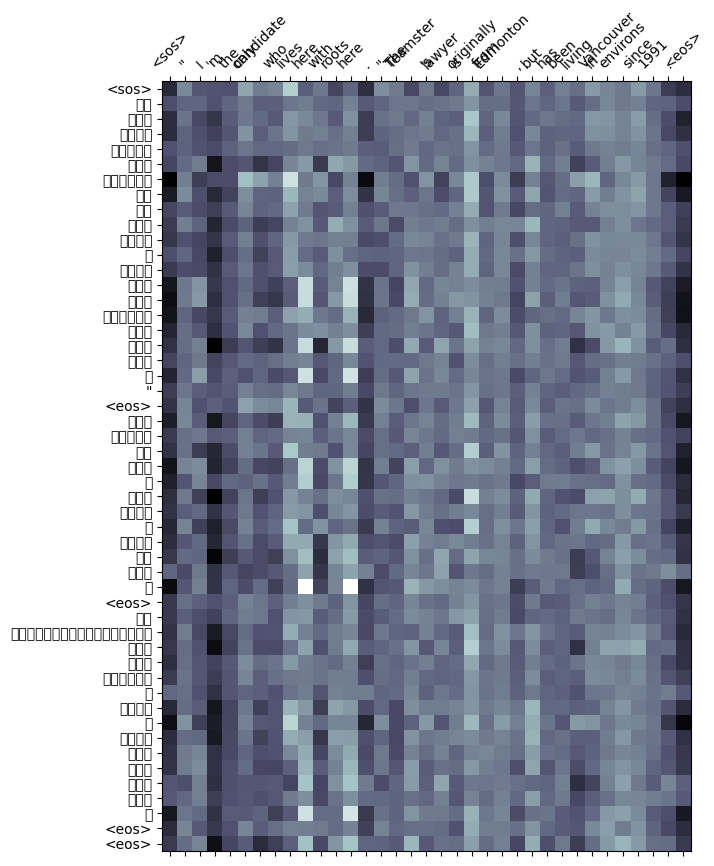

In [85]:
display_attention(src_tokens, trg_tokens, attention)